<a href="https://colab.research.google.com/github/Paaaark/Kaggle/blob/main/titanic/titanic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
!pip install tensorflow_decision_forests

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.8/489.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 34.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 65.9 MB/s eta 0:00:00
  Attempting uninstall: wrapt
    Found existing installation: wrapt 1.15.0
    Uninstalling wrapt-1.15.0:
      Successfully uninstalled wrapt-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2.13.0
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Atte

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import preprocessing
import tensorflow_decision_forests as tfdf
import csv

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Kaggle/titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Fill nan values with 0
for key in df.keys():
  df[key] = df[key].fillna(0)

survival_rate = {}
for key in df.keys():
  if key in ['PassengerId', 'Survived', 'Name', 'Ticket', 'Cabin']:
    continue
  survival_rate[key] = {};
  for ind in df.index:
    if df[key][ind] in survival_rate[key]:
      survival_rate[key][df[key][ind]][df['Survived'][ind]] += 1
    else:
      survival_rate[key][df[key][ind]] = [0, 0]
      survival_rate[key][df[key][ind]][df['Survived'][ind]] += 1

age_count = {}
for i in range(0, 80, 10):
  age_count[i] = [0, 0]
for entry in survival_rate['Age'].keys():
  age = int(entry / 10) * 10
  if age > 70:
    age = 70
  age_count[age][0] += survival_rate['Age'][entry][0]
  age_count[age][1] += survival_rate['Age'][entry][1]
survival_rate['Age'] = age_count

fare_count = {}
for i in range(0, 120, 20):
  fare_count[i] = [0, 0]
for entry in survival_rate['Fare'].keys():
  fare = int(entry / 20) * 20
  if fare > 100:
    fare = 100
  fare_count[fare][0] += survival_rate['Fare'][entry][0]
  fare_count[fare][1] += survival_rate['Fare'][entry][1]
survival_rate['Fare'] = fare_count

survival_rate

{'Pclass': {3: [372, 119], 1: [80, 136], 2: [97, 87]},
 'Sex': {'male': [468, 109], 'female': [81, 233]},
 'Age': {0: [149, 90],
  10: [61, 41],
  20: [143, 77],
  30: [94, 73],
  40: [55, 34],
  50: [28, 20],
  60: [13, 6],
  70: [6, 1]},
 'SibSp': {1: [97, 112],
  0: [398, 210],
  3: [12, 4],
  4: [15, 3],
  2: [15, 13],
  5: [5, 0],
  8: [7, 0]},
 'Parch': {0: [445, 233],
  1: [53, 65],
  2: [40, 40],
  5: [4, 1],
  3: [2, 3],
  4: [4, 0],
  6: [1, 0]},
 'Fare': {0: [372, 143],
  20: [114, 86],
  40: [23, 31],
  60: [23, 23],
  80: [3, 20],
  100: [14, 39]},
 'Embarked': {'S': [427, 217], 'C': [75, 93], 'Q': [47, 30], 0: [0, 2]}}

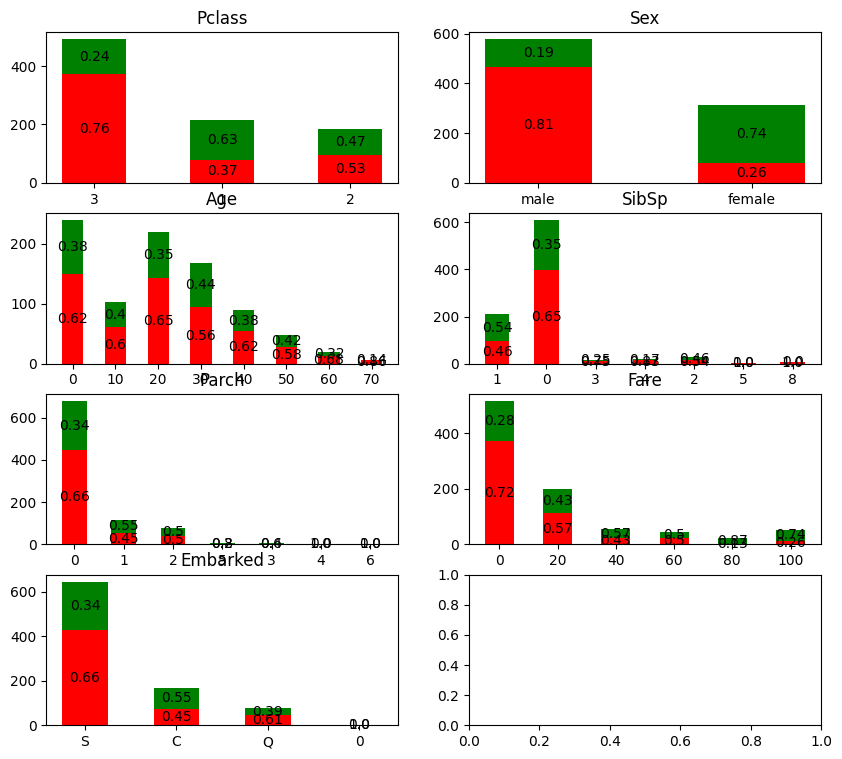

In [ ]:
fix, axes = plt.subplots(4, 2, figsize=(10, 9))
keys = survival_rate.keys()
counter = 0
for key in keys:
  ax = axes[int(counter / 2)][counter % 2]
  x_axis = survival_rate[key].keys()
  # y_axis_1 = not survived, y_axis_2 = survived
  y_axis_1 = []
  y_axis_2 = []
  label_1 = []
  label_2 = []
  for x in x_axis:
    total = float(survival_rate[key][x][0] + survival_rate[key][x][1])
    y_axis_1.append(survival_rate[key][x][0])
    y_axis_2.append(survival_rate[key][x][1])
    label_1.append(round(survival_rate[key][x][0] / total, 2))
    label_2.append(round(survival_rate[key][x][1] / total, 2))

  x_axis = list(map(lambda x: str(x), survival_rate[key].keys()))
  bar1 = ax.bar(x_axis, y_axis_1, color='red', width=0.5)
  bar2 = ax.bar(x_axis, y_axis_2, bottom=y_axis_1, color='green', width=0.5)
  ax.bar_label(bar1, label_1, label_type='center')
  ax.bar_label(bar2, label_2, label_type='center')
  ax.set_title(key)
  counter = counter + 1

In [4]:
def process_data(data):
  train_data = data
  train_data = train_data.drop(axis=1, labels=['PassengerId', 'Name', 'Ticket', 'Cabin'])

  age = list(train_data.loc[:, 'Age'])
  for i in range(len(age)):
    age[i] = min(age[i], 70)
  train_data.loc[:, 'Age'] = age

  fare = list(train_data.loc[:, 'Fare'])
  for i in range(len(fare)):
    fare[i] = min(fare[i], 100)
  train_data.loc[:, 'Fare'] = fare

  train_data['Sex'] = train_data['Sex'].map({
      'male': 0,
      'female': 1
  })
  train_data['Embarked'] = train_data['Embarked'].map({
      'S': 0,
      'C': 1,
      'Q': 2,
      0 : 3
  })

  try:
    train_y = train_data.pop('Survived')
  except KeyError:
    train_x = tf.convert_to_tensor(train_data)
    scaler = preprocessing.StandardScaler().fit(train_x)
    train_x = scaler.transform(train_x)
    return train_x

  train_x = tf.convert_to_tensor(train_data)
  # scaler = preprocessing.StandardScaler().fit(train_x)
  # train_x = scaler.transform(train_x)

  return train_x, train_y

In [5]:
def save_model(model, acc, name):
  model.save('/content/drive/MyDrive/Kaggle/titanic/models/' + name + '.keras')
  plt.plot(acc)
  plt.title(name)
  plt.savefig('/content/drive/MyDrive/Kaggle/titanic/accuracy/' + name + '.jpg')

In [12]:
train_x, train_y = process_data(df)

model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(units=7, activation='relu', input_shape=[7,]))
model.add(tf.keras.layers.Dense(units=30, activation='relu'))
model.add(tf.keras.layers.Dense(units=30, activation='relu'))
model.add(tf.keras.layers.Dense(units=1, activation='relu'))

model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['acc'])
hist = model.fit(train_x, train_y, epochs=30, verbose=False,
                 validation_split=0.2)

In [10]:
train_x, train_y = process_data(df)
model = tfdf.keras.RandomForestModel()
model.compile(metrics=["acc"])
hist = model.fit(train_x, train_y)

Use /tmp/tmpow7zziw4 as temporary training directory
Reading training dataset...
Training dataset read in 0:00:00.326504. Found 891 examples.
Training model...
Model trained in 0:00:00.961526
Compiling model...
Model compiled.


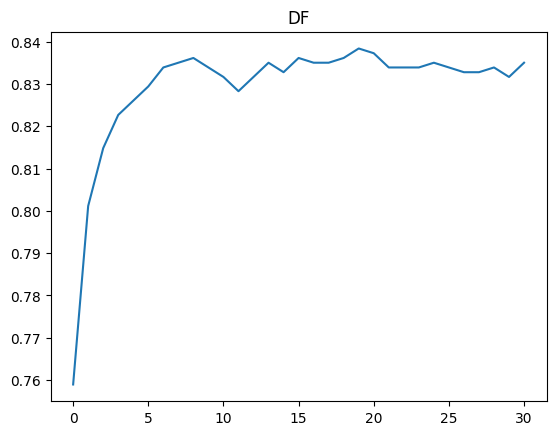

In [20]:
logs = model.make_inspector().training_logs()
acc = []
for log in logs:
  acc.append(log.evaluation.accuracy)
save_model(model, acc, 'DF')

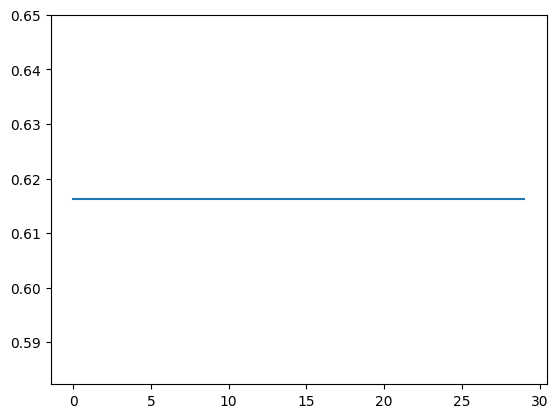

In [15]:
save_model(model, hist.history['acc'], '7-30-30-1;RELU;SGD')

In [21]:
test_df = pd.read_csv('/content/drive/MyDrive/Kaggle/titanic/test.csv')
test_df.head()
test_x = process_data(test_df)
prediction = model.predict(test_x)

14/14 [==============================] - 0s 2ms/step


In [26]:
for i in range(len(prediction)):
  prediction[i] = np.round(prediction[i])

In [35]:
with open('/content/drive/MyDrive/Kaggle/titanic/submissions/DF.csv', 'w', encoding='UTF8', newline='') as f:
  writer = csv.writer(f)
  writer.writerow(['PassengerId', 'Survived'])
  for i in range(len(prediction)):
    currentRow = [892 + i, int(prediction[i][0])]
    writer.writerow(currentRow)